In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader as data_reader
import datetime
import ta
from sklearn import preprocessing, linear_model, metrics, neighbors, feature_selection, ensemble, multioutput, svm
from statsmodels import regression

In [3]:
appl = data_reader.get_data_yahoo('AAPL', start=datetime.datetime(2001, 1, 1), end=datetime.datetime(2019, 8, 9))
spy = data_reader.get_data_yahoo('SPY', start=datetime.datetime(2001, 1, 1), end=datetime.datetime(2019, 8, 9))
appl.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2001-01-02,1.089286,1.040179,1.062500,1.062500,113078000.0,0.924482
2001-01-03,1.191964,1.031250,1.035714,1.169643,204268400.0,1.017707
2001-01-04,1.321429,1.200893,1.295759,1.218750,184849000.0,1.060436
2001-01-05,1.241071,1.147321,1.209821,1.169643,103089000.0,1.017707
2001-01-08,1.213170,1.138393,1.209821,1.183036,93424800.0,1.029361


In [4]:
appl.describe()

,High,Low,Open,Close,Volume,Adj Close
count,4680.000000,4680.000000,4680.000000,4680.000000,4.680000e+03,4680.000000
mean,59.227883,58.098642,58.676359,58.677083,1.165798e+08,54.727269
std,60.710405,59.693577,60.194961,60.212747,9.681993e+07,58.504425
min,0.942143,0.908571,0.927857,0.937143,9.835000e+06,0.815409
25%,6.736786,6.598214,6.663571,6.643214,4.818730e+07,5.780266
50%,35.111429,34.330713,34.683571,34.713572,8.871345e+07,30.204314
75%,99.892502,98.042501,98.682501,98.782499,1.540704e+08,91.709465
max,233.470001,229.779999,230.779999,232.070007,8.432424e+08,227.839798


In [5]:
appl.dropna(inplace=True)
spy.dropna(inplace=True)

In [6]:
return_appl = appl['Adj Close'].pct_change()[1:]
return_spy = spy['Adj Close'].pct_change()[1:]

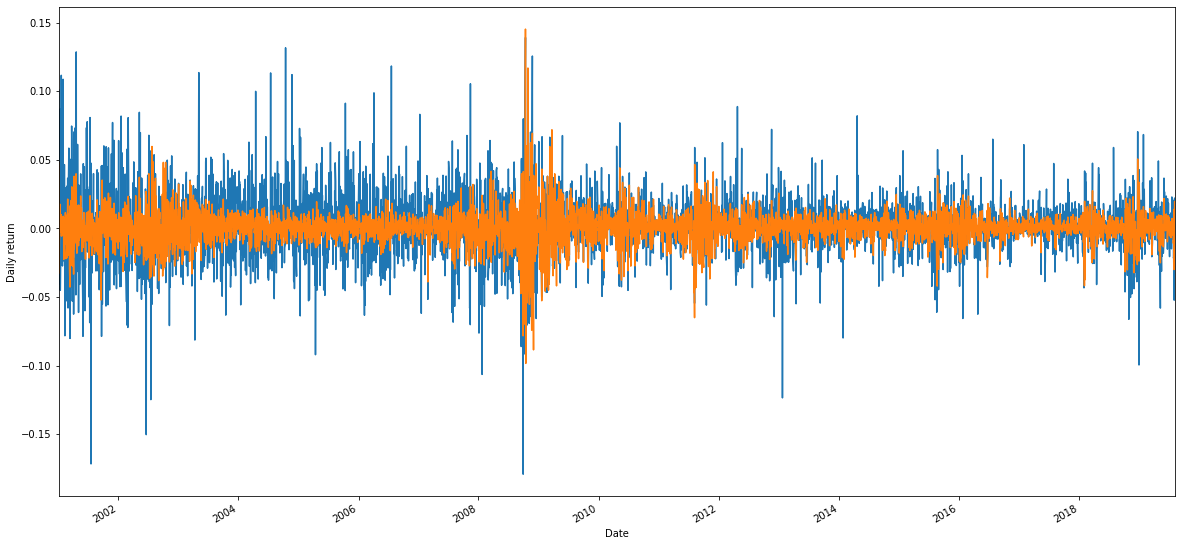

In [7]:
plt.figure(figsize=(20,10))
return_appl.plot()
return_spy.plot()
plt.ylabel("Daily return") 
plt.show()

In [8]:
def calculate_alpha_and_beta(x, y, periods):
    x_values = x['Adj Close'].pct_change()[1:].values
    y_values = y['Adj Close'].pct_change()[1:].values
    
    betas = [None for index in range(periods + 1)]
    alphas = [None for index in range(periods + 1)]
    
    for index in range(len(x_values) - periods):
        X = x_values[index: (index + periods)]
        Y = y_values[index: (index + periods)]

        X = sm.add_constant(X)
        model = regression.linear_model.OLS(Y, X).fit()
        
        alphas.append(model.params[0])
        betas.append(model.params[1])

    y['alpha'] = np.array(alphas) 
    y['beta'] = np.array(betas) 
        
    return y.copy()

In [9]:
appl = calculate_alpha_and_beta(spy, appl, 64)

In [10]:
def fourier_transforms(data, numbers):
    close_fft = np.fft.fft(np.asarray(data['Adj Close'].tolist()))
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_list = np.asarray(fft_df['fft'].tolist())

    for num_ in [3, 6, 9, 100]:
        fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
        data['Fourier_{}'.format(num_)] = np.fft.ifft(fft_list_m10)
    
    return data

In [11]:
def get_technical_indicators(dataset, spy):
    # Assuming 0 for now
    daily_rf_rate = 0
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Adj Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Adj Close'].rolling(window=21).mean()
    dataset['SMA100'] = dataset['Adj Close'].rolling(window=100).mean()

    # Create MACD
    dataset['26ema'] = dataset['Adj Close'].ewm(span=26, adjust=False).mean()
    dataset['12ema'] = dataset['Adj Close'].ewm(span=12, adjust=False).mean()
    dataset['MACD'] = (dataset['12ema'] - dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Adj Close'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['Adj Close'].ewm(span=100).mean()
    dataset['ROC'] = ((dataset['Adj Close'] - dataset['Adj Close'].shift(100)) / dataset['Adj Close'].shift(100)) * 100
    dataset['SPY_SMA_100'] = spy['Adj Close'].rolling(window=100).mean()
    
    # Compute Volatility on spy and index 
    dataset['SPY_Vol'] = np.log(spy['Adj Close'] / spy['Adj Close'].shift(1)).rolling(window=60).std() * np.sqrt(252)
    dataset['Log_Returns'] = np.log(dataset['Adj Close'] / dataset['Adj Close'].shift(1))
    dataset['Vol'] = dataset['Log_Returns'].rolling(window=60).std() * np.sqrt(252)
    dataset['Sharpe_Ratio'] = (dataset['Log_Returns'].rolling(window=60).mean() - daily_rf_rate) / dataset['Vol']
    
    return dataset

In [12]:
appl = get_technical_indicators(appl, spy)
appl.dropna(inplace=True)
appl.describe()

,High,Low,Open,Close,Volume,Adj Close,ma7,ma21,SMA100,26ema,...,20sd,upper_band,lower_band,ema,ROC,SPY_SMA_100,SPY_Vol,Log_Returns,Vol,Sharpe_Ratio
count,4580.000000,4580.000000,4580.000000,4580.000000,4.580000e+03,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,...,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000
mean,60.487236,59.335435,59.924770,59.925416,1.164906e+08,55.893626,55.764288,55.454240,53.776219,55.347813,...,1.591247,58.636733,52.271747,53.807112,14.830453,132.366011,0.161155,0.001077,0.332192,0.004629
std,60.761875,59.745607,60.246235,60.264470,9.744218e+07,58.598945,58.484502,58.197130,56.667325,58.062855,...,1.876879,61.277489,55.200205,56.621128,27.280823,61.390064,0.095472,0.022293,0.129037,0.008704
min,0.942143,0.908571,0.927857,0.937143,9.835000e+06,0.815409,0.827306,0.860453,0.896770,0.863244,...,0.015558,0.924447,0.671332,0.902513,-54.964303,63.017444,0.049786,-0.197470,0.103573,-0.018383
25%,8.627857,8.337857,8.528214,8.508929,4.727588e+07,7.403627,7.291623,7.253475,6.842763,7.369599,...,0.269071,7.888846,6.567145,7.112726,-0.911313,86.056159,0.106341,-0.009538,0.232196,-0.001384
50%,37.124287,36.366428,36.719286,36.752857,8.821820e+07,31.978696,31.718377,31.699938,30.050067,31.570441,...,0.986109,33.394677,29.531916,30.167419,13.890772,107.866123,0.130904,0.000942,0.310198,0.004718
75%,100.725718,98.852497,99.842501,99.962143,1.544265e+08,92.593307,92.472814,92.083176,94.224057,92.388400,...,2.198864,96.162370,87.645340,94.767155,28.689641,182.095063,0.190176,0.012190,0.402581,0.010534
max,233.470001,229.779999,230.779999,232.070007,8.432424e+08,227.839798,223.224060,219.401228,205.928441,218.637046,...,15.069447,228.119122,211.761917,205.801093,141.700234,287.762976,0.755843,0.130194,0.931176,0.033084


In [13]:
print(appl.columns)

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'alpha', 'beta',
       'ma7', 'ma21', 'SMA100', '26ema', '12ema', 'MACD', '20sd', 'upper_band',
       'lower_band', 'ema', 'ROC', 'SPY_SMA_100', 'SPY_Vol', 'Log_Returns',
       'Vol', 'Sharpe_Ratio'],
      dtype='object')


In [14]:
appl['close'] = appl['Adj Close']
appl = appl.drop(['Adj Close', 'Close', 'Volume'], axis=1)

In [15]:
appl['alpha'].describe()

count     4580.000000
unique    4580.000000
top          0.000771
freq         1.000000
Name: alpha, dtype: float64

In [16]:
appl['beta'].describe()

count     4580.000000
unique    4580.000000
top          1.040408
freq         1.000000
Name: beta, dtype: float64

In [17]:
columns = list(appl.columns)
print(columns)

['High', 'Low', 'Open', 'alpha', 'beta', 'ma7', 'ma21', 'SMA100', '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band', 'ema', 'ROC', 'SPY_SMA_100', 'SPY_Vol', 'Log_Returns', 'Vol', 'Sharpe_Ratio', 'close']


In [18]:
def split_data(data):
        total_length = len(data)
        train_index = round(0.8 * total_length)
        
        train = data[:int(train_index), :]
        test = data[int(train_index):, :]
        
        return train, test

In [19]:
train, test = split_data(appl.values)

In [20]:
def normalize_data(train, test):
        normalizer = preprocessing.Normalizer()
        train = normalizer.fit_transform(train)
        test = normalizer.transform(test)        
        return train, test

In [21]:
train, test = normalize_data(train, test)

In [22]:
print("Train data shape: ", train.shape)
print("Test data shape: ", test.shape)

Train data shape:  (3664, 22)
Test data shape:  (916, 22)


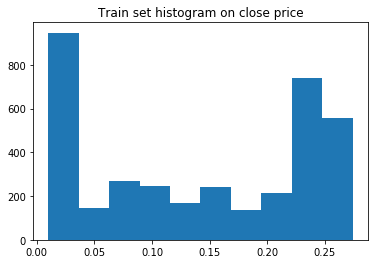

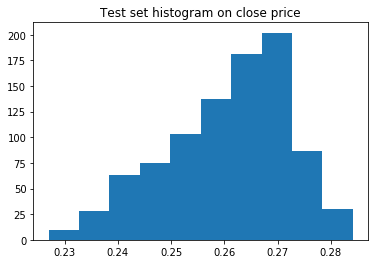

In [23]:
plt.hist(train[:,-1])
plt.title("Train set histogram on close price") 
plt.show()

plt.hist(test[:,-1])
plt.title("Test set histogram on close price") 
plt.show()

In [24]:
def formate_data(data, x_len, y_len):
        x_s = []
        y_s = []
        
        for index in range(len(data) - (x_len + y_len)):
            # We delete the close price from the xs
            x_s.append(data[index: (index + x_len), :-1])
            # We just want the close price as target variable
            y_s.append(data[(index + x_len):(index + x_len + y_len), -1])
        
        x_s = np.array(x_s)
        y_s = np.array(y_s)
        
        return x_s, y_s

In [25]:
x_train, y_train = formate_data(train, 24, 7)
x_test, y_test = formate_data(test, 24, 7)

print("X train shape:", x_train.shape)
print("Y train shape:", y_train.shape)

print("X test shape:", x_test.shape)
print("Y test shape:", y_test.shape)

X train shape: (3633, 24, 21)
Y train shape: (3633, 7)
X test shape: (885, 24, 21)
Y test shape: (885, 7)


In [26]:
X = np.reshape(x_train, (3633, 24 * 21))
y = y_train
reg = linear_model.LinearRegression().fit(X, y)
print(reg.score(X, y))

0.9979327102357586


/anaconda3/envs/sp500/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [27]:
Xt = np.reshape(x_test, (885, 24 * 21))
yt = y_test
pred = reg.predict(Xt)
print("yt shape: ", yt.shape)
print("pred shape: ", pred.shape)

yt shape:  (885, 7)
pred shape:  (885, 7)


In [28]:
mse = metrics.mean_squared_error(yt, pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  3.1618823291253525e-05


In [29]:
def plot_results_against_true_data(tested_data, true_data, title="Results comparison"):
        plt.figure(figsize = (15,6))
        # style
        plt.style.use('seaborn-darkgrid')

        plt.plot(
            range(len(tested_data)), 
            tested_data, 
            marker='', 
            color="blue", 
            linewidth=0.5, 
            alpha=1, 
            label="Predicted Data"
        )

        plt.plot(
            range(len(true_data)), 
            true_data, 
            marker='', 
            color="black", 
            linewidth=0.5, 
            alpha=0.8, 
            label="Real Data"
        )

        plt.legend(loc=2, ncol=2)
        plt.title(title, loc='left', fontsize=12, fontweight=0, color='orange')
        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.show()

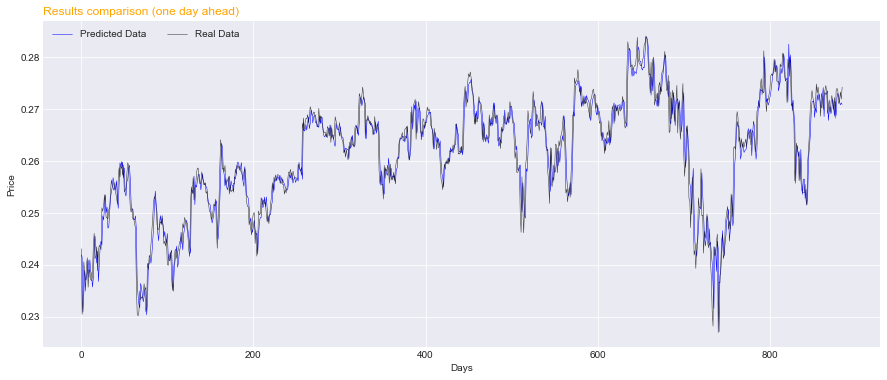

In [30]:
plot_results_against_true_data(pred[:,0], yt[:,0], title="Results comparison (one day ahead)")

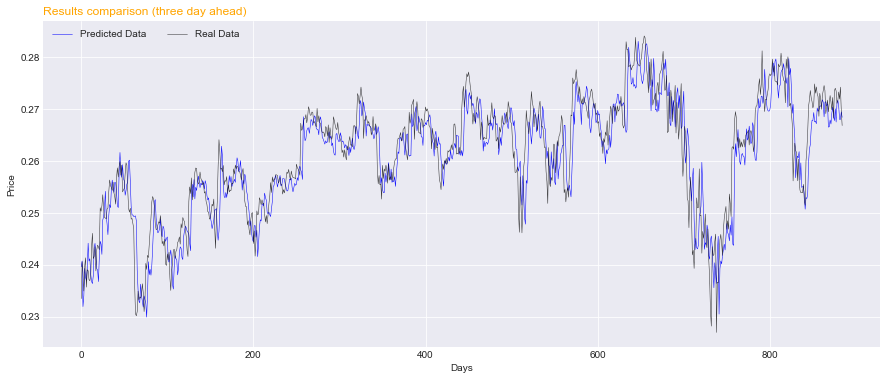

In [31]:
plot_results_against_true_data(pred[:,2], yt[:,2], title="Results comparison (three day ahead)")

In [32]:
print(pred[:,0].max())

0.28386781543421546


In [33]:
reg = ensemble.GradientBoostingRegressor(n_estimators=350)
reg = multioutput.MultiOutputRegressor(reg, n_jobs=-1).fit(X, y)
print(reg.score(X, y))

0.9996848744446961


In [34]:
Xt = np.reshape(x_test, (885, 24 * 21))
yt = y_test
pred = reg.predict(Xt)
print("yt shape: ", yt.shape)
print("pred shape: ", pred.shape)

yt shape:  (885, 7)
pred shape:  (885, 7)


In [35]:
mse = metrics.mean_squared_error(yt, pred)
print("Score: ", reg.score(Xt, pred))
print("Mean Squared Error: ", mse)

Score:  1.0
Mean Squared Error:  0.0002479312812125191


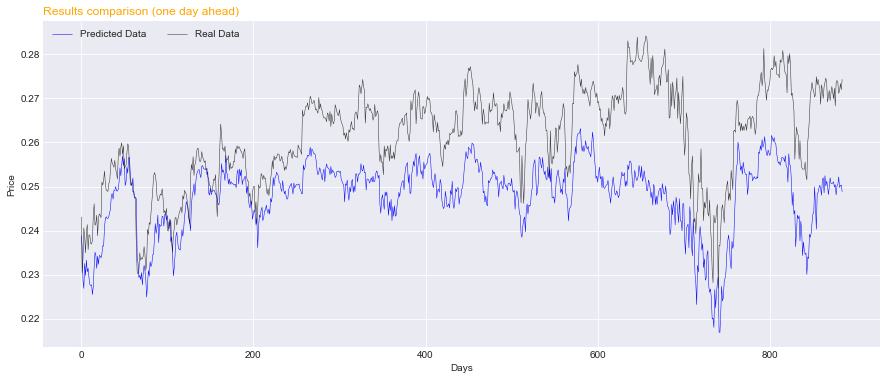

In [36]:
plot_results_against_true_data(pred[:,0], yt[:,0], title="Results comparison (one day ahead)")

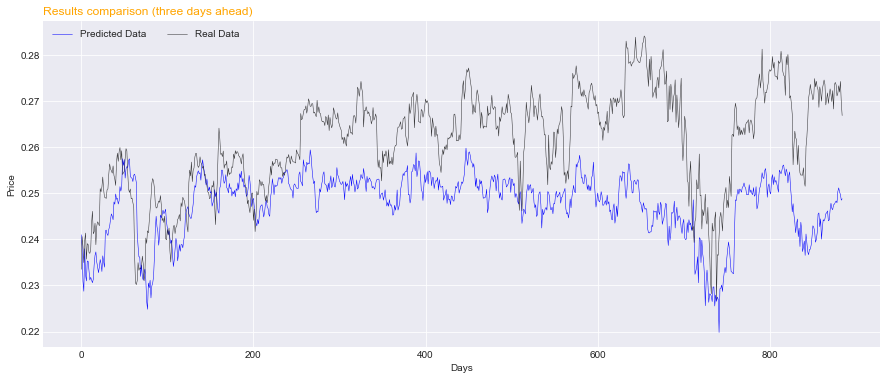

In [37]:
plot_results_against_true_data(pred[:,2], yt[:,2], title="Results comparison (three days ahead)")

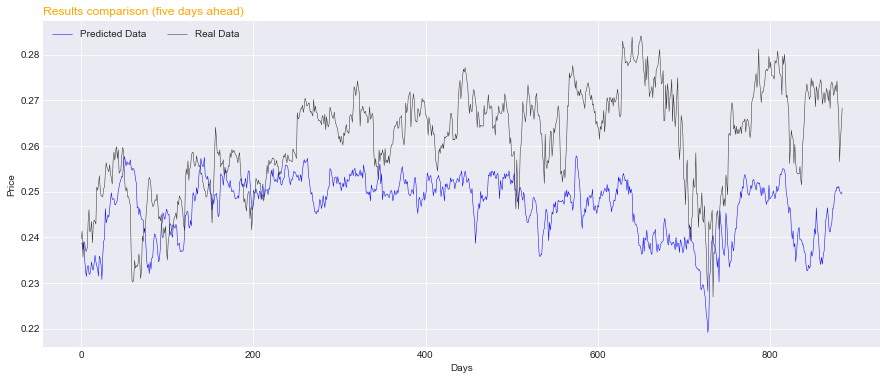

In [38]:
plot_results_against_true_data(pred[:,6], yt[:,6], title="Results comparison (five days ahead)")

In [57]:
X = np.reshape(x_train, (3633, 24 * 21))
y = y_train
reg = neighbors.KNeighborsRegressor(n_neighbors=35).fit(X, y)
print(reg.score(X, y))

0.9966311983904161


/anaconda3/envs/sp500/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [59]:
Xt = np.reshape(x_test, (885, 24 * 21))
yt = y_test
pred = reg.predict(Xt)
print("yt shape: ", yt.shape)
print("pred shape: ", pred.shape)

yt shape:  (885, 7)
pred shape:  (885, 7)


In [60]:
mse = metrics.mean_squared_error(yt, pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  0.0001626993898863688


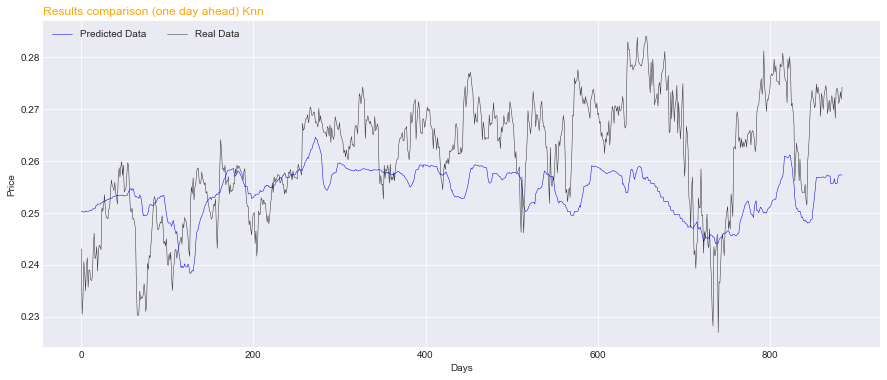

In [61]:
plot_results_against_true_data(pred[:,0], yt[:,0], title="Results comparison (one day ahead) Knn")

In [62]:
from tensorflow.keras.layers import Activation, Dense, GRU
from tensorflow.keras.models import Sequential

In [63]:
def build(amount_of_features, seq_len):
            
        model = Sequential()

        model.add(GRU(
            units=256,
            activation="tanh",
            return_sequences=True,
            dropout=0.2,
            input_shape=(seq_len, amount_of_features)
            )
        )

        model.add(GRU(
            units=256,
            activation="tanh",
            return_sequences=False,
            dropout=0.2
            )
        )

        model.add(Dense(64, activation="relu"))
        model.add(Dense(7, activation="linear"))

        model.summary()

        model.compile(
            optimizer="Nadam",
            loss="mse"
        )

        return model

In [66]:
reg = build(21, 24)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 24, 256)           213504    
_________________________________________________________________
gru_3 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 455       
Total params: 624,391
Trainable params: 624,391
Non-trainable params: 0
_________________________________________________________________


In [67]:
def train_model(
        model, 
        x_train, 
        y_train,
        batch_size,
        epochs
    ):
    
        history = model.fit(
            x=x_train, 
            y=y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.1,
            shuffle=False
        )

        return history, model

In [68]:
hist, model = train_model(reg, x_train, y_train, 256, 10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3269 samples, validate on 364 samples
Epoch 1/10
3269/3269 [==============================] - 31s 9ms/sample - loss: 0.0040 - val_loss: 0.0113
Epoch 2/10
3269/3269 [==============================] - 22s 7ms/sample - loss: 0.0019 - val_loss: 6.0759e-04
Epoch 3/10
3269/3269 [==============================] - 22s 7ms/sample - loss: 0.0022 - val_loss: 9.7434e-05
Epoch 4/10
3269/3269 [==============================] - 30s 9ms/sample - loss: 0.0011 - val_loss: 3.2444e-04
Epoch 5/10
3269/3269 [==============================] - 23s 7ms/sample - loss: 9.4443e-04 - val_loss: 7.8565e-04
Epoch 6/10
3269/3269 [==============================] - 21s 6ms/sample - loss: 0.0011 - val_loss: 8.5616e-04
Epoch 7/10
3269/3269 [==============================] - 21s 6ms/sample - loss: 8.9241e-04 - val_loss: 6.6142e-04
Epoch 8/10
3269/3269 [==============================] - 22s 7ms/sample - loss: 7.5234e-04 - 

In [69]:
scores = model.evaluate(x_test, y_test, verbose=0)
print(scores)

0.0010336748414441397


In [70]:
results = model.predict(x_test)
print(results.shape)

(885, 7)


In [71]:
mse = metrics.mean_squared_error(y_test, results)
print("Mean Squared Error: ", mse)

Mean Squared Error:  0.0010336747874951891


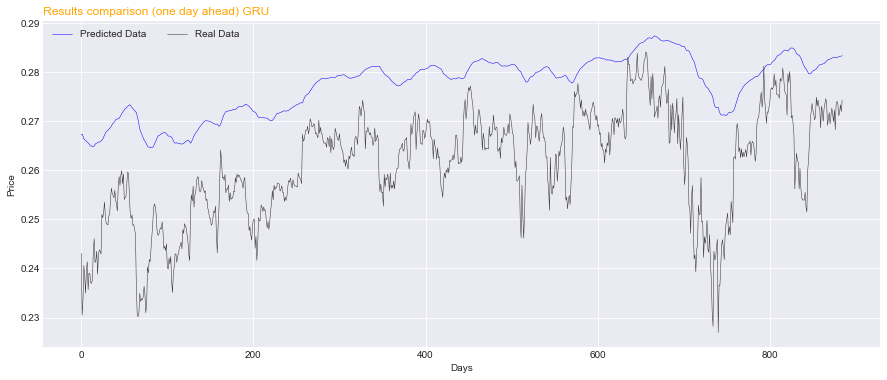

In [72]:
plot_results_against_true_data(results[:,0], y_test[:,0], title="Results comparison (one day ahead) GRU")